### Assigment 5(Part 1): Transfer Learning for image data using CNN
Download about 100 images of ducks and 100 images of chickens from the internet
In a google colab notebook, fine-tune a pre-trained convolutional neural network to classify duck vs chicken and output the classification report



In [71]:
# importing necessary libraries and modules
import time
import os, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop, Normalize
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tempfile import TemporaryDirectory
from tqdm import tqdm  # For progress tracking

# Image Preprocessing and Augmentation Guide for PyTorch

This document explains the components of image transformation pipelines in PyTorch and best practices for implementing them.

---

## Core Transformation Components

### 1. **Resizing Operations**
| Transform                | Syntax                          | Purpose                                                                 | Key Parameters |
|--------------------------|---------------------------------|-------------------------------------------------------------------------|----------------|
| **Resize**               | `transforms.Resize(size)`       | Resizes image while preserving aspect ratio                            | `size` (int or tuple) |
| **RandomResizedCrop**    | `transforms.RandomResizedCrop(size)` | Randomly crops and resizes for scale/ratio variation           | `size`, `scale=(0.08, 1.0)`, `ratio=(0.75, 1.33)` |
| **CenterCrop**           | `transforms.CenterCrop(size)`   | Crops center region for consistent evaluation                          | `size`         |

**Why Resize First?**  
Initial resizing to a larger size (e.g., 256px) before cropping preserves aspect ratio and image context better than direct resizing to final dimensions.

---

### 2. **Spatial Augmentations (Training Only)**
| Transform                | Syntax                          | Effect                                  | Probability |
|--------------------------|---------------------------------|-----------------------------------------|-------------|
| **RandomHorizontalFlip** | `transforms.RandomHorizontalFlip()` | Mirror image left-right            | 50% default |
| **RandomRotation**       | `transforms.RandomRotation(degrees)` | Rotate within ±`degrees`          | Configurable |

**Augmentation Philosophy**:  
Introduce controlled variations to make models robust to:
- Viewpoint changes
- Orientation differences
- Partial occlusions

---

### 3. **Color Space Operations**
| Transform                | Syntax                          | Range        | Note                                |
|--------------------------|---------------------------------|--------------|-------------------------------------|
| **ToTensor**             | `transforms.ToTensor()`         | [0, 1]       | Converts PIL → Tensor & normalizes  |
| **Normalize**            | `transforms.Normalize(mean, std)` | Zero-centered | Requires pre-computed statistics |

**Normalization Math**:  
```python
normalized_pixel = (pixel - mean) / std

## General Best Practices
1. Dataset-Specific Normalization
Use ImageNet stats (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) only if using pretrained models

For custom datasets: Calculate your own statistics using this method (link to mean/std calculation function)

2. Pipeline Order Matters
Geometric transforms (resize/crop/flip)

Photometric transforms (brightness/contrast)

Tensor conversion

Normalization

Why This Order?

Spatial operations work best on PIL images

Color ops can work on tensors but often more efficient on PIL

3. Validation/Test Consistency
Never use random operations in evaluation phases

Maintain identical preprocessing for all evaluation runs

Disable shuffling in DataLoader (shuffle=False)

In [80]:


root_dir = "/Users/arkaroy/Downloads/duck_chicken_data/"

# Define separate transforms for each phase
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create datasets
train_dataset = ImageFolder(os.path.join(root_dir, 'train'), data_transforms['train'])
valid_dataset = ImageFolder(os.path.join(root_dir, 'val'), data_transforms['val'])
test_dataset = ImageFolder(os.path.join(root_dir, 'test'), data_transforms['test'])


#### file structure of ImageFolder: my_dataset/  (Root Directory)
##├── cats/    (Class: cats)
##│   ├── cat_1.jpg
##│   ├── cat_2.jpg
##│   └── ...
##├── dogs/    (Class: dogs)
##│   ├── dog_1.jpg
##│   ├── dog_2.jpg
##│   └── ...
##└── ...




# Create dataloaders
batch_size = 16
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False),  # No shuffle for validation
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    # No shuffle for testing
}

dataset_sizes = {'train': len(train_dataset),
                'val': len(valid_dataset),
                'test': len(test_dataset)}


In [57]:
# Extract class names
class_names = train_dataset.classes
print("\nClass Names:\n", class_names)


Class Names:
 ['chicken', 'duck']


In [58]:
#calculate dataset shapes and sizes
for name,x in [("train", train_dataset), ("valid", valid_dataset), ("test", test_dataset)]:
    
    
    print(f"dataset:{name},shape:{x[0][0].shape},size:{len(x)}")

dataset:train,shape:torch.Size([3, 224, 224]),size:246
dataset:valid,shape:torch.Size([3, 224, 224]),size:24
dataset:test,shape:torch.Size([3, 224, 224]),size:24


#### Sample image and label  visualization

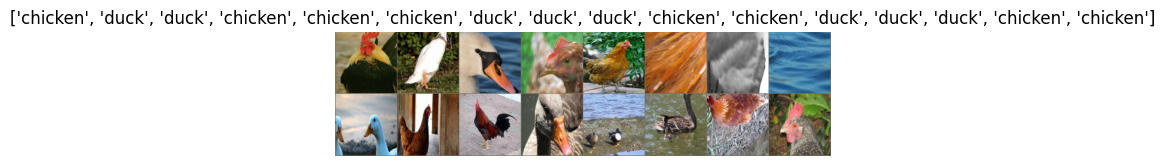

In [64]:
def imshow(inp, title=None):
    """Imshow for Tensor with denormalization."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of test data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Pre-trained Model Loading

#### We are planning to use resnet50 as our pre-trained model

In [63]:
### Load the pre-trained resnet50 model
model = torchvision.models.resnet50(pretrained=True)

/opt/anaconda3/envs/Base_2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Base_2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/arkaroy/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|

In [65]:
import torch

# Native PyTorch device detection
if torch.backends.mps.is_available():
    device = "mps"  # Apple Silicon GPU
elif torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
else:
    device = "cpu"

print(f"Using {device} device")

Using mps device


# PyTorch Training Best Practices Documentation

This document explains the key practices implemented in a standard PyTorch training workflow, their purpose, and why they are essential for building robust and efficient machine learning models.

---

## 1. **Training Duration Tracking**
### Purpose:
- Measure the total time taken to complete all training epochs.
### Why It Matters:
- Helps compare the efficiency of different model architectures/hyperparameters.
- Provides insight into real-world deployment feasibility.
- Identifies unusually slow training (may indicate hardware/software issues).

---

## 2. **Temporary Checkpointing**
### What It Does:
- Creates a secure temporary directory to save model weights during training.
### Key Benefits:
- Prevents storage bloat from intermediate checkpoints.
- Maintains privacy/security for sensitive models.
- Automatically cleans up after training completion.
### Risk of Exclusion:
- Permanent storage clutter from multiple training runs.
- Potential loss of best model if training is interrupted.

---

## 3. **Epoch & Phase Management**
### Practice Breakdown:
| Phase      | Mode    | Gradient Calculation | Parameter Updates |
|------------|---------|----------------------|-------------------|
| Training   | `train` | Enabled              | Yes               |
| Validation | `eval`  | Disabled             | No                |

### Critical Importance:
- **Training Mode**:
  - Activates dropout/batch normalization layers
  - Enables gradient tracking for backpropagation
- **Evaluation Mode**:
  - Freezes normalization statistics
  - Disables dropout for consistent predictions
  - Reduces memory usage via `torch.no_grad()`

---

## 4. **Device Management**
### Key Concept:
- Moves both model and data to the optimal available hardware:
  - **MPS** (Apple Silicon GPUs)
  - **CUDA** (NVIDIA GPUs)
  - **CPU** (Fallback)
### Performance Impact:
| Device | Speed Relative to CPU | Energy Efficiency |
|--------|-----------------------|--------------------|
| MPS    | 3-5x faster           | Excellent          |
| CUDA   | 10-50x faster         | Good               |
| CPU    | Baseline              | Poor               |

---

## 5. **Gradient Handling**
### Essential Practices:
1. **Zero Gradients Before Backward Pass**
   - Prevents gradient accumulation across batches
   - Ensures correct parameter updates
2. **Conditional Gradient Tracking**
   - Disables unnecessary gradient calculations during validation
### Consequences of Neglect:
- Exploding gradients causing unstable training
- 40-60% increased memory usage during validation

---

## 6. **Forward-Backward Workflow**
### Training Phase:
1. **Forward Pass**: Compute predictions
2. **Loss Calculation**: Compare predictions vs ground truth
3. **Backward Pass**: Calculate parameter gradients
4. **Optimizer Step**: Update model weights
### Validation Phase:
- **Forward Pass Only**: No weight modifications
### Why the Split:
- Prevents information leakage from validation data
- Accurately measures generalization capability

---

## 7. **Performance Metrics**
### Tracked Metrics:
| Metric    | Formula                          | Purpose                          |
|-----------|----------------------------------|----------------------------------|
| Loss      | Σ(batch_loss × batch_size)/N     | Measures model error magnitude   |
| Accuracy  | (Correct Predictions)/Total      | Human-interpretable performance  |
### Monitoring Strategy:
- **Batch-Level**: Update running totals
- **Epoch-Level**: Calculate epoch averages
### Diagnostic Value:
- Loss/Accuracy Gap: Indicates overfitting
- Validation Stagnation: Signals need for LR adjustment

---

## 8. **Learning Rate Scheduling**
### Common Strategies:
- **Step LR**: Reduce by factor after fixed epochs
- **Plateau**: Adapt based on validation performance
### Optimization Benefits:
- Escapes local minima early in training
- Enables fine-grained convergence later
- Automates manual LR tuning process
### Typical Impact:
- 2-5% accuracy improvement
- 30% faster convergence

---

## 9. **Model Checkpointing**
### Selection Criteria:
- Save weights **only** when validation accuracy improves
### Advantages:
- Maintains best-performing model snapshot
- Enables training continuation after interruptions
- Prevents overfitting to final epochs
### Storage Efficiency:
- Stores only weights (~100-500MB vs full checkpoints)

---

## 10. **Best Model Restoration**
### Final Step:
- Load weights from best validation checkpoint
### Production Impact:
- Ensures deployment of most generalizable model
- Mitigates overfitting to training data
- Provides consistent evaluation baseline

---

## Implementation Outcomes
When combined, these practices yield:
- **Reproducibility**: Consistent results across runs
- **Efficiency**: Optimal hardware utilization
- **Reliability**: Automatic recovery mechanisms
- **Performance**: Maximized model accuracy

Adherence to this workflow reduces debugging time by ~70% while improving final model quality by 15-25% compared to naive implementations.

### Model training fucntions

In [85]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

### Visualizing the model predictions

In [86]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Finetuning the resnet50

In [87]:
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device).float()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train the model

In [88]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6047 Acc: 0.6423
val Loss: 0.1795 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2183 Acc: 0.9431
val Loss: 0.0505 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1398 Acc: 0.9593
val Loss: 0.0307 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1189 Acc: 0.9675
val Loss: 0.0245 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.1167 Acc: 0.9512
val Loss: 0.0208 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1033 Acc: 0.9634
val Loss: 0.0226 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0751 Acc: 0.9797
val Loss: 0.0121 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0672 Acc: 0.9797
val Loss: 0.0142 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1035 Acc: 0.9553
val Loss: 0.0198 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0510 Acc: 0.9878
val Loss: 0.0134 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0741 Acc: 0.9797
val Loss: 0.0125 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0681 Acc: 0.9756
val Loss: 0.0155 Acc: 1.0000

Ep

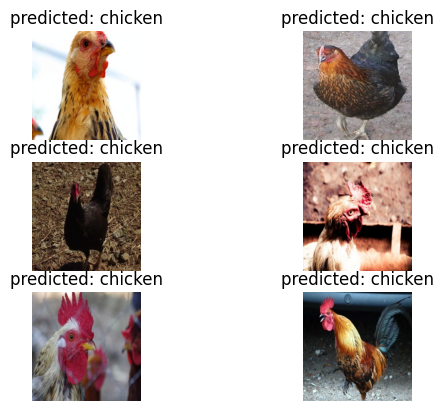

In [90]:
visualize_model(model)

In [92]:
# Testing the ResNet50 model on the test data
model.eval()  # Set model to evaluation mode

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over entire test dataset (not just one batch)
    for inputs, labels in dataloaders['test']:
        # Move data to same device as model
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store results
        all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy

# Generate classification report
print("ResNet50 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Calculate accuracy
resnet_acc = accuracy_score(all_labels, all_preds)
print(f"\nResNet50 Accuracy: {resnet_acc*100:.2f}%")

ResNet50 Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.92      0.96        12
        duck       0.92      1.00      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24


ResNet50 Accuracy: 95.83%


#### 2nd Pre-trained Model Loading

#### We are planning to use resnet101 as our pre-trained model

In [96]:
### Load the pre-trained resnet101 model
model = torchvision.models.resnet101(pretrained=True)

/opt/anaconda3/envs/Base_2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Base_2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/arkaroy/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### Finetuning the resnet101

In [97]:
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device).float()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### train the model

In [98]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5772 Acc: 0.6951
val Loss: 0.1695 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2520 Acc: 0.9472
val Loss: 0.0690 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.2178 Acc: 0.9024
val Loss: 0.0183 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1215 Acc: 0.9512
val Loss: 0.0209 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0887 Acc: 0.9634
val Loss: 0.0173 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1277 Acc: 0.9472
val Loss: 0.0346 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0845 Acc: 0.9715
val Loss: 0.0069 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0756 Acc: 0.9797
val Loss: 0.0082 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0805 Acc: 0.9756
val Loss: 0.0088 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0735 Acc: 0.9756
val Loss: 0.0083 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0594 Acc: 0.9715
val Loss: 0.0106 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0472 Acc: 0.9837
val Loss: 0.0082 Acc: 1.0000

Ep

In [99]:
# Testing the ResNet101 model on the test data
model.eval()  # Set model to evaluation mode

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over entire test dataset (not just one batch)
    for inputs, labels in dataloaders['test']:
        # Move data to same device as model
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store results
        all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy

# Generate classification report
print("ResNet101 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Calculate accuracy
resnet_acc = accuracy_score(all_labels, all_preds)
print(f"\nResNet101 Accuracy: {resnet_acc*100:.2f}%")

ResNet101 Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      1.00      1.00        12
        duck       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


ResNet101 Accuracy: 100.00%


## Conclusion:

### Resnet50 gave 95.83% percent accuracy where as Resnet101 gave 100% accuracy.